# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Homework 2 (209) - Bayesian: Particle Filters




**Harvard University**<br/>
**Spring 2022**<br/>
**Instructors**: Mark Glickman & Pavlos Protopapas<br/>
**Content**: Kristen Hunter & Blake Bullwinkel


<hr style="height:2pt">

In [1]:
#PLEASE RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

<a id="instructions"></a>

<hr style="height:2pt">

### INSTRUCTIONS

- This homework can be submitted **in pairs**.

- To submit your assignment follow the instructions given in Canvas.

- Please **restart the kernel and run the entire notebook again before you submit.**

- Running cells out of order is a common pitfall in Jupyter Notebooks. To make sure your code continues to work, restart the kernel and rerun your notebook periodically while working through this assignment. 

- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. **Please use only the libraries provided in those imports.**

- Please use `.head(...)` when viewing data. Do not submit a notebook that is **excessively long**. 

- In questions that require code to answer, such as "calculate and report $R^2$", do not just output the value from a cell. Write a `print(...)` function that clearly labels the output, includes a reference to the calculated value, and rounds it to a reasonable number of digits. **Do not hard code values in your printed output**. For example, this is an appropriate print statement:
```python
print(f'The R^2 is {R:.4f}')
```
- **Your plots MUST be clearly labeled and easy to read,** including clear labels for the $x$ and $y$ axes, a descriptive title ("MSE plot" is NOT a descriptive title; "Training and validation MSE at varying degree polynomial regression models" on the other hand is descriptive), a legend when appropriate, and clearly formatted text and graphics.

- **Your code may also be evaluated for efficiency and clarity.** As a result, correct output is not always sufficient for full credit.

<hr style="height:2pt">

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline 
import matplotlib.pyplot as plt
from scipy.stats import poisson
from IPython.display import display

np.random.seed(209)

<a id="contents"></a>

## Notebook Contents

- [**Problem 1 [3 pts]: Modeling**](#part1)
- [**Problem 2 [3 pts]: Conceptual review**](#part2)
- [**Problem 3 [10 pts]: Particle filter**](#part3)
- [**Problem 4 [3 pts]: Results**](#part4)
- [**Problem 5 [3 pts]: Particles**](#part5)

The data provided tracks a population of little owls over time. Researchers put out nesting boxes, and at regular time intervals conducted a survey of the population of owls in the nesting boxes.

Citation: Fitsum Abadi, Olivier Gimenez, Bruno Ullrich, Raphael Arlettaz, and Michael Schaub. (2010). [Estimation of immigration rate using integrated population models.](https://besjournals.onlinelibrary.wiley.com/doi/abs/10.1111/j.1365-2664.2010.01789.x) Journal of Applied Ecology 47, 393-400.

We are interested in estimating the abundance of breeding females in the owl population. We will consider a state-space model/hidden markov model for owl abundance.

In [3]:
# read in the owl population data
def read_data():
    owl = pd.read_csv('data/owls.csv')
    return owl

<a id="part1"></a>

# Part 1: Modeling 

[Return to contents](#contents)

The *true* population abundance of breeding females at time $t$ is $x_t$. We assume this value is latent/unobserved. The *observed* count of breeding females at time $t$ is $y_t$.

The observed count may differ from the true abundance for two reasons.

First, the survey could undercount the number of breeding females. Some of the females may not be in the nesting box at the time of the survey, or some could choose to nest elswhere.

Second, the survey could overcount the number of breeding females. Female owls begin breeding at 1 year old, and it can be difficult for a researcher to tell if an owl has reached breeding age. Thus, in the survey, some of the females may be incorrectly counted as breeding females even if they are immature.

Let’s start with setting up model components. These model components will form the building blocks of a particle filter algorithm.

<a id="part1questions"></a>

### <div class='exercise'>Part 1: Questions</div> 

[Return to contents](#contents)

**1.1** *Observed counts*: We can model the observed process as a function of the latent process as Poisson, centered on the true abundance.

$$
y_t | x_t \sim Pois(x_t)
$$

Write a function that takes in a value of $x_t$ and a value of $y_t$ and calcutes the probability of the observed $y_t$ conditional on $x_t$.

**1.2** *Latent transitions*: We can model the latent process of owl abundance using a Poisson distribution based on the previous time point and a parameter $\alpha$. Note that for this assignment, we will take $\alpha$ to be known.

$$
x_t | x_{t-1} \sim Pois(\alpha x_{t-1})
$$

Write a function that takes in an assumed $\alpha$ and a latent state $x_{t−1}$ and randomly draws $N$ possible values of $x_t$.

**1.3** *Initialization*: Write a function that initializes $N$ possible values of the latent state at time 1 ($x_1$). The values should be drawn from a Poisson distribution with assumed mean `init_lambda`.

<a id="part1solutions"></a>
## Part 1: Solutions

[Return to contents](#contents)

<div class='exercise-r'>

**1.1**  *Observed counts*: We can model the observed process as a function of the latent process as Poisson, centered on the true abundance.

$$
y_t | x_t \sim Pois(x_t)
$$

Write a function that takes in a value of $x_t$ and a value of $y_t$ and calcutes the probability of the observed $y_t$ conditional on $x_t$.



</div>

In [4]:
def p_observation(xt_mu, yt_k):
    return poisson.pmf(k = yt_k, mu=xt_mu)

p_observation(xt_mu=1, yt_k=[1, 2, 3])


array([0.36787944, 0.18393972, 0.06131324])

<div class='exercise-r'>

**1.2**  *Latent transitions*: We can model the latent process of owl abundance using a Poisson distribution based on the previous time point and a parameter $\alpha$. Note that for this assignment, we will take $\alpha$ to be known.

$$
x_t | x_{t-1} \sim Pois(\alpha x_{t-1})
$$

Write a function that takes in an assumed $\alpha$ and a latent state $x_{t−1}$ and randomly draws $N$ possible values of $x_t$.



</div>

In [5]:
def transition(xt_prior_mu, alpha, n):
    return poisson.rvs(mu=alpha * xt_prior_mu, size=n)

transition(xt_prior_mu = 10, alpha = .5, n = 90)

array([ 7,  5,  6,  5,  6,  4,  0,  7, 13,  7,  6,  5,  8,  1,  1,  7,  2,
        7,  7,  3,  8,  4,  4,  2,  6, 10,  5,  1,  6,  7,  9,  4,  7,  7,
        6, 12,  4,  5,  4,  3,  4,  3,  6,  7,  4,  5,  4,  6,  3,  4,  5,
        2,  5,  9,  7,  2,  4,  4,  3,  3,  5,  6,  4,  5,  8,  4,  9,  6,
        3,  6,  4,  8,  3,  5,  4,  1,  6,  3,  5,  6,  4,  5,  1,  5,  4,
        4,  7,  1, 11,  2])

<div class='exercise-r'>

**1.3**  *Initialization*: Write a function that initializes $N$ possible values of the latent state at time 1 ($x_1$). The values should be drawn from a Poisson distribution with assumed mean `init_lambda`.

</div>

In [6]:
def initialize(n, init_lambda):
    x1 = transition(init_lambda, alpha=1, n = n)
    return x1

initialize(10, 2)


array([1, 2, 2, 2, 2, 3, 3, 3, 2, 2])

<a id="part2"></a>

# Part 2: Conceptual review

Note: these questions can be briefly answered with 1-3 sentences.

[Return to contents](#contents)

<a id="part2questions"></a>

### <div class='exercise'>Part 2: Questions</div> 

[Return to contents](#contents)

**2.1** Why does this setting lend itself to a particle filter?

**2.2** What is the purpose of the resampling step in particle filters?

**2.3** What could happen if you forgot to normalize weights before conducting resampling?

<a id="part2solutions"></a>
## Problem 2: Solutions

[Return to contents](#contents)

<div class='exercise-r'>

**2.1**  Why does this setting lend itself to a particle filter?



</div>

I think the main reason is because we are approximating a value that we will be never be able to determine with 100% certainty, i.e.: the true population of breeding owls. We infer what the "true" value could be based its the empirical evidence (observable samples). Finally a state space model is useful in this case because the "true" value is not static and is always changing because there are breeding owls that die and young owls that mature at an unknown (or unmeasurable rate). 

<div class='exercise-r'>

**2.2**  What is the purpose of the resampling step in particle filters?



</div>

Since you are updating the probability using a latent transition model, you need to resample your data with the updated probability.

<div class='exercise-r'>

**2.3**  What could happen if you forgot to normalize weights before conducting resampling?

</div>

If we did not normalized and resampled using multinomial sampling, some values would not be picked ever. By normalizing we guarantee that even the smallest values will have a chance to be sampled again.

<a id="part3"></a>

# Part 3: Particle Filter 

[Return to contents](#contents)


We will focus on the problem of filtering, which means we are interested in the distribution of the latent states conditional on the observed states. Specifically, we interested in the distribution $p(x_t∣y_{1:t})$, where $y_{1:t}$ denotes the vector of all observed time points from $1$ to $t$. Assume there are $T$ total time points, and we are interested in the latent states over all time points: $p(x_1∣y_1)$, $p(x_2∣y_{1:2})$, up to $p(x_T∣y_{1:T})$.

In particular, our inference target is the posterior mean at each time point: $\mu_t = E(x_t∣y_{1:t})$.

<a id="part3questions"></a>

### <div class='exercise'>Part 3: Questions</div> 

[Return to contents](#contents)

**3.1** *Setup*: Before we begin, we will need one more function for the particle filter algorithm. Write a function that takes in a vector of values and a vector of weights, and performs multinomial resampling.

**3.2** *Algorithm*: Write a particle filter function for conducting inference on the latent state $x_t$ conditional on $y_{1:t}$ for each time point $t=1$ to $T$. Your function should return a $T$-length vector called `mu_hat` that contains the estimated posterior mean, $\hat{\mu}_t$, at each time point. Begin at time $t=1$ and initialize the particles. At the end of this step, you will have filled out the first value of $\hat{\mu}$. Then, finish the algorithm for time $t>1$ to $T$.

## Part 3: Solutions

[Return to contents](#contents)

<div class='exercise-r'>

**3.1**  *Setup*: Before we begin, we will need one more function for the particle filter algorithm. Write a function that takes in a vector of values and a vector of weights, and performs multinomial resampling.



</div>

In [7]:
def resample(X=None, W=[1,1,1]):
    resampling_ls = []
    W = np.array(W)
    # normalize weights
    normalized_w = W/sum(W)
    
    # array with cumulative sum of weights
    cumsum = 0
    cum_weights = []
    for w in normalized_w:
        cumsum += w
        cum_weights.append(cumsum)

    # randomly pick number between 0 and 1
    picks = np.random.uniform(0,1, size=len(W))
    
    # resample based on normalized weights 
    for pick in picks:
        for w in sorted(cum_weights):
            if pick > w: continue
            else: 
                idx_to_sample = np.where(cum_weights == w)[0][0]
                resampling_ls.append(X[idx_to_sample])
                break
            
    return np.array(resampling_ls)

resample(X = [10,30,80,80,80,80, 80, 100, 10, 10], W = [1,3,8, 8, 8, 8, 8, 10, 1, 1])


array([100,  80,  80,  10,  80,  80, 100, 100,  80,  80])

<div class='exercise-r'>

**3.2**  *Algorithm*: Write a particle filter function for conducting inference on the latent state $x_t$ conditional on $y_{1:t}$ for each time point $t=1$ to $T$. Your function should return a $T$-length vector called `mu_hat` that contains the estimated posterior mean, $\hat{\mu}_t$, at each time point. Begin at time $t=1$ and initialize the particles. At the end of this step, you will have filled out the first value of $\hat{\mu}$. Then, finish the algorithm for time $t>1$ to $T$.

The arguments to your function should include `alpha`, the number of particles `N`, and `init_lambda`.
</div>

In [8]:
def particle_filter(alpha, N, init_lambda, T):
    # initialize
    y_t = np.array(read_data()['breed.females'].values)
    theta_i_0 = initialize(init_lambda=init_lambda, n=N)

    # calculate weights
    y0 = y_t[0]
    w_i_0 = np.array([p_observation(xt_mu=theta, yt_k=y0) for theta in theta_i_0])
    W_i_0 = w_i_0/w_i_0.sum()
    
    mu_hat_0 = W_i_0 * theta_i_0
    mu_hat = [mu_hat_0.sum()]
    
    for t in range(1,T):
        #resample
        resample_theta_i_0 = resample(X=theta_i_0, W=W_i_0)
        # transition
        theta_i_1 = transition(xt_prior_mu=resample_theta_i_0, alpha=alpha, n = N)
        
        # calculate new_weights
        yi = y_t[t] 
        w_i_1 = np.array([p_observation(xt_mu=theta, yt_k=yi) for theta in theta_i_1])
        W_i_1 = w_i_1/w_i_1.sum()
        
        # calculate mu_hat
        mu_hat_1 = W_i_1 * theta_i_1
        mu_hat.append(mu_hat_1.sum())
        
        # reset variables
        theta_i_0 = theta_i_1
        W_i_0 = W_i_1
        
    
    return np.array(mu_hat)

particle_filter(alpha=1.1, N=10, init_lambda=10, T=10)

array([12.6052472 , 11.25082593, 10.16535538, 14.76431045, 18.08424777,
       18.83565385, 16.26911608, 15.66368779, 11.87885463, 12.32108351])

<a id="part4"></a>

# Part 4: Results

[Return to contents](#contents)

<a id="part4questions"></a>

### <div class='exercise'>Part 4: Questions</div> 

[Return to contents](#contents)

**4.1** Run your function with `alpha = 1.1`,  `N = 30`, and `init_lambda = 9`. Then, plot both the observed counts $y_t$ and the estimated posterior mean $\hat{\mu}_t$ values over time. Briefly comment on the plot: do you see any patterns? Do you have any intution behind the patterns you see? (1-2 sentences is sufficient).

**4.2** How do the results change as you change $N$ to be larger or smaller? Explain any patterns you see.

**4.3** How do the results change as you change `init_lambda` to be larger or smaller? Explain any patterns you see.

<a id="part4solutions"></a>
## Part 4: Solutions

[Return to contents](#contents)

<div class='exercise-r'>

**4.1**  Run your function with `alpha = 1.1`,  `N = 30`, and `init_lambda = 9`. Then, plot both the observed counts $y_t$ and the estimated posterior mean $\hat{\mu}_t$ values over time. Briefly comment on the plot: do you see any patterns? Do you have any intution behind the patterns you see? (1-2 sentences is sufficient).



</div>

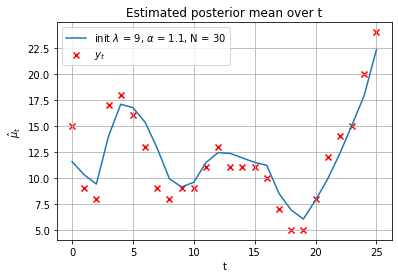

In [9]:
df = read_data()
T = df.shape[0]
t = np.arange(T)
yt = df['breed.females'].values
N=30
alpha  =1.1
for i in [9]:
    mu = particle_filter(alpha=alpha, N=N, init_lambda=i, T=T)
    plt.plot(t, mu, label = 'init $\lambda$ = {}, $\\alpha$ = {}, N = {}'.format(i, alpha, N))
plt.scatter(t, yt, label = '$y_t$', color='r', marker='x')
plt.title('Estimated posterior mean over t')
plt.xlabel('t')
plt.ylabel('$\hat{\mu}_t$')
plt.legend()
plt.grid()
plt.show()
# plt.show()


It appears like estimate improve as time (t) passes. I think this is because  we start with a guess for lambda (or mu) that we update with likelier estimates thanks to the  weighted resampling.

<div class='exercise-r'>

**4.2**  How do the results change as you change `N` to be larger or smaller? Explain any patterns you see.



</div>

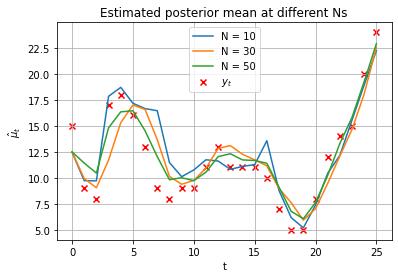

In [10]:
for i in [10, 30, 50]:
    mu = particle_filter(alpha=1.1, N=i, init_lambda=9, T=T)
    plt.plot(t, mu, label = 'N = {}'.format(i))
plt.scatter(t, yt, label = '$y_t$', color='r', marker='x')
plt.title('Estimated posterior mean at different Ns')
plt.xlabel('t')
plt.ylabel('$\hat{\mu}_t$')
plt.legend()
plt.grid()
plt.show()

After redrawing the graph above several times, it looks like the major difference is that the higher Ns consistently follow the data closer than the lower Ns. This makes sense because the higher Ns translate to generating more $x_t$ values on each step. Having more $x_t$  improves our ability to resample likelier estimates.

<div class='exercise-r'>

**4.3**  How do the results change as you change `init_lambda` to be larger or smaller? Explain any patterns you see.

</div>

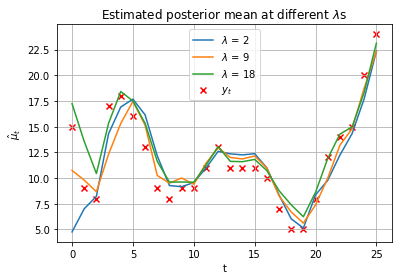

In [12]:
for i in [2,9,18]:
    mu = particle_filter(alpha=1.1, N=30, init_lambda=i, T=T)
    plt.plot(t, mu, label = '$\lambda$ = {}'.format(i))
plt.scatter(t, yt, label = '$y_t$', color='r', marker='x')
plt.title('Estimated posterior mean at different $\lambda$s')
plt.xlabel('t')
plt.ylabel('$\hat{\mu}_t$')
plt.legend()
plt.grid()
plt.show()
# plt.show()

Modifying `init_lambda` only affects the initial predictions. The predictions at varying lambdas appear to converge as time passes.

<a id="part5"></a>

# Part 5: Particles 

Let's consider the resampling step in more detail.

[Return to contents](#contents)

<a id="part5questions"></a>

### <div class='exercise'>Part 5: Questions</div> 

[Return to contents](#contents)

**5.1** The function was modified to track how many *unique* values are taken by the collection of particles at each time point (after resampling). (Note: no need to do this yourself). The results are below.

```
[ 8 10  9 10 11 10 10  8  9  8 10  8  9  9  7 10  9  8  9  8  8  7 11  9
 10 12]
```

How does the number of unique values compare to the number of particles? Is there a pattern for how the number of unique values varies over time?

**5.2** The algorithm was re-run with `alpha = 1.5`. The following is again the number of unique values:

```
[ 9  7  7 10  6  4  6  5  6  2  2  6  5  3  5  4  1  1  2  1  3  1  3  3
  3  2]
```

How has the number of unique values changed? Do you see patterns in the number of unique values as the algorithm progresses? Explain why we are tracking this number, and how it could impact the success of the algorithm–do you still trust inference about $\hat{\mu}_t$?

**5.3** Try to rerun your function with `alpha = 3`. Does your function still run? If it doesn’t, explain why you think it isn’t succeeding. If it does, explain why the algorithm might still be experiencing problems. The number of unique values has changed when we change `alpha`. What does this tell you about the modeling assumptions?

<a id="part5solutions"></a>

## Part 5: Solutions

[Return to contents](#contents)

<div class='exercise-r'>

**5.1**  The function was modified to track how many *unique* values are taken by the collection of particles at each time point (after resampling). (Note: no need to do this yourself). The results are below.

```
[ 8 10  9 10 11 10 10  8  9  8 10  8  9  9  7 10  9  8  9  8  8  7 11  9
 10 12]
```

How does the number of unique values compare to the number of particles? Is there a pattern for how the number of unique values varies over time?



</div>

In [ ]:
uniques = [ 8,10, 9,10,11,10,10, 8, 9, 8,10, 8, 9, 9, 7,10, 9, 8, 9, 8, 8, 7,11, 9,10,12]
t = np.arange(len(uniques))
plt.plot(t, uniques)
plt.title('Number of unique values over time')
plt.ylabel('count')
plt.xlabel('t')
plt.show()

I expect the number of unique values to be smaller than the number of particles because you are bound to have repeated particles. 

With regards to how the uniques values vary over time, I do not see a clear pattern after plotting the results above. 

<div class='exercise-r'>

**5.2**  The algorithm was re-run with `alpha = 1.5`. The following is again the number of unique values:

```
[ 9  7  7 10  6  4  6  5  6  2  2  6  5  3  5  4  1  1  2  1  3  1  3  3
  3  2]
```

How has the number of unique values changed? Do you see patterns in the number of unique values as the algorithm progresses? Explain why we are tracking this number, and how it could impact the success of the algorithm–do you still trust inference about $\hat{\mu}_t$?



</div>

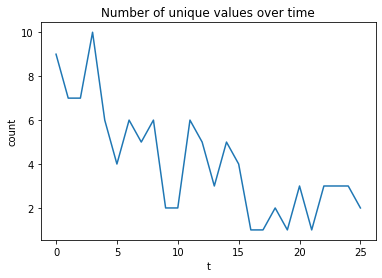

In [13]:
uniques = [ 9, 7, 7,10, 6, 4, 6, 5, 6, 2, 2, 6, 5, 3, 5, 4, 1, 1, 2, 1, 3, 1, 3, 3,  3, 2]
t = np.arange(len(uniques))
plt.plot(t, uniques)
plt.title('Number of unique values over time')
plt.ylabel('count')
plt.xlabel('t')
plt.show()

The number of unique values now appears to decrease as time passes. You may want to track this number to evaluate if you are converging on a solution or not. Decreasing the number of unique values does not seem like a good thing because it implies that you are not considering a broad range of possibilities because their probabilities are so low. 

<div class='exercise-r'>

**5.3**  Try to rerun your function with `alpha = 3`. Does your function still run? If it doesn’t, explain why you think it isn’t succeeding. If it does, explain why the algorithm might still be experiencing problems. The number of unique values has changed when we change `alpha`. What does this tell you about the modeling assumptions?

</div>

The function does not run when `alpha = 3` because the resampling step fails. It fails because there are no samples to pick from (their probabilities are ~0). It is important to consider what value of alpha to select when modeling a state-space process because it affects how you adjust your latent variables ($x_t | x_{t-1} \sim Pois(\alpha x_{t-1})$ in this case).

High values of alpha allow you to explore the range of possibilities faster, but it risks stopping your prediction process. Small alphas might not allow you to react fast to your latent observations, making for a laggy predictor. 

**THE END!** 🦉